### Grading
This week's lab doesn't have any auto-graded components. Each question in this notebook has an accompanying Peer Review question. Although the lab shows as being ungraded, you need to complete the notebook to answer the Peer Review questions. <br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** 

### Validate Button
This week's lab doesn't have any auto-graded components. Each question in this notebook has an accompanying Peer Review question. Although the lab shows as being ungraded, you need to complete the notebook to answer the Peer Review questions. 

You do not need to use the Validate button for this lab since there are no auto-graded components. If you hit the Validate button, it will time out given the number of visualizations in the notebook. Cells with longer execution times cause the validate button to time out and freeze. ***This notebook's Validate button time-out does not affect the final submission grading.*** 

# Clustering RNA sequences to identify cancer types

In this assignment, we will use clustering algorithms on RNA sequence data to identify cancer types.
Since the [whole data](https://www.synapse.org/#!Synapse:syn4301332) (from [Cancer Genome Atlas Pan-Cancer project](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3919969/)) is very big, we will use a [subset data from UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#). The subset data contains only 5 labels; BRCA, KIRC, COAD, LUAD and PRAD. The meanings of those labels are as below.

|Abbreviation|Cancer|
|:----:|:-------:|
|LUSC|Lung squamous cell carcinoma |
|READ |Rectum adenocarcinoma |
|GBM |Glioblastoma multiforme|
|BLCA |Bladder Urothelial Carcinoma|
|UCEC |Uterine Corpus Endometrioid Carcinoma|
|COAD |Colon adenocarcinoma|
|OV |Ovarian serous cystadenocarcinoma|
|LAML |Acute Myeloid Leukemia|
|HNSC |Head and Neck squamous cell carcinoma|
|LUAD |Lung adenocarcinoma|
|BRCA |Breast invasive carcinoma|
|KIRC |Kidney renal clear cell carcinoma|

Although we can use the data for supervised learning model training, we will not use these labels for training, but use them for evaluation.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import time

In [3]:
# Read data. Do not change the variable names (data, label)
data = pd.read_csv('data/data.csv')
label = pd.read_csv('data/labels.csv')
data=data.drop('Unnamed: 0',axis=1)
label=label.drop('Unnamed: 0',axis=1)

### A. [Peer Review] Perform basic data inspection or EDA on the pandas dataframe.
- How many observations?
- How many features?

In [4]:
# perform basic data inspection such as getting the number of observations and number of features
# you can also display part of the dataframe or run data.info() 
# your code here
print(data.info())
print(data.head())
num_observations, num_features = data.shape
print(f"\nNumber of Observations: {num_observations}")
print(f"Number of Features: {num_features}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5 MB
None
   gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
0     0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
1     0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
2     0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
3     0.0  3.663618  4.507649  6.659068  10.196184     0.0  7.843375   
4     0.0  2.655741  2.821547  6.539454   9.738265     0.0  6.566967   

     gene_7  gene_8  gene_9  ...  gene_20521  gene_20522  gene_20523  \
0  0.591871     0.0     0.0  ...    4.926711    8.210257    9.723516   
1  0.000000     0.0     0.0  ...    4.593372    7.323865    9.740931   
2  0.452595     0.0     0.0  ...    5.125213    8.127123   10.908640   
3  0.434882     0.0     0.0  ...    6.076566    8.792959   10.141520   
4  0.360982     0.0     0.0  ...    5.9

- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What do those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br>
Answer the Peer Review question about this section. 

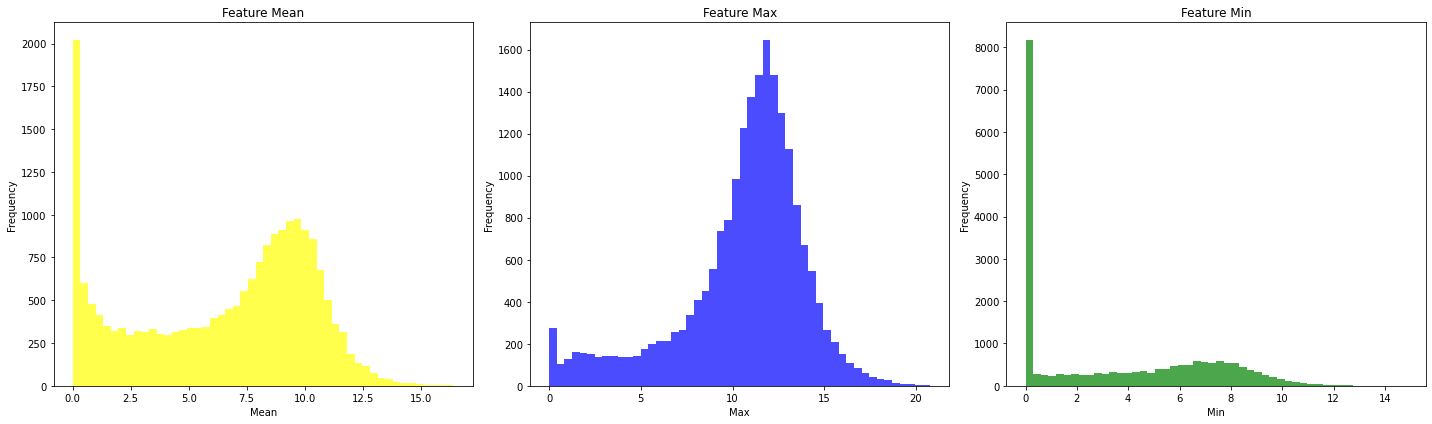

In [5]:
# draw histograms of mean, max and min values in each feature 
# your code here
def populate_plot(plot, n, feature, color, title, xlabel, ylabel):
    plt.subplot(1, 3, n)
    plt.hist(feature, bins=50, color=color, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

# Compute mean, max, and min for each feature
f_means = data.mean(axis=0)
f_max = data.max(axis=0)
f_min = data.min(axis=0)

# Plot histograms for mean, max, and min
plt.figure(figsize=(20, 6))

populate_plot(plt, 1, f_means, 'yellow', 'Feature Mean', 'Mean', 'Frequency')
populate_plot(plt, 2, f_max, 'blue', 'Feature Max', 'Max', 'Frequency')
populate_plot(plt, 3, f_min, 'green', 'Feature Min', 'Min', 'Frequency')


plt.tight_layout()
plt.show()

- If we were to train a "supervised" learning model, how would you deal with such large feature dimension? 
- Even after feature dimension reduction, still the number of useful features may be enormous. How it would impact performance or runtime of certain supervised learning algorithms? Which algorithms would suffer from high dimension features than others and why? 
- How it would impact performance or runtime of an unsupervised learning algorithm?
- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br> <br>
Anwer these questions in this week's Peer Review assignment. 

### B. [Peer Review] Build a hierarchical clustering model
Let's build a model using hierarchical clustering. Hierarchical clustering module is available from `sklearn.cluster.AgglomerativeClustering`. You can choose linkage type and metric. Please check its documentation for more details.

**a) Number of clusters vs distance threshold**
Oftentimes hierarchical clustering does not need to know the number of clusters in advance. Instead, one needs to choose threshold distance/similarity to cut the dendrogram later. The AgglomerativeClustering module lets you specify either the number of clusters (n_clusters) or the threshold (distance_threshold). Based on our data, which should we choose to set to which value and why? <br> <br>
Answer this question in the Peer Review assignment. 

#### b) Guess which metric?
Can you guess which metric to use (distance-based vs. similarity-based) and why? 
This question is not graded, but we encourage you to share your thoughts with the class. See the ungraded discussion prompt for this week's material. 

#### c) Build a model
Build a model using n_clusters=5 option. Choose any metric and linkage type at first. Display the clustering result labels (you can just print out the result). Do not change the variable (model) name. Answer the question about this section in the Peer Review.

In [6]:
# build a model using n_clusters=5 option

# your code here
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
# metric: default=”euclidean”, use affinity
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model.fit(data)

print(f"Cluster labels:\n{model.labels_}")

Cluster labels:
[2 3 2 2 0 2 1 2 0 2 0 1 2 0 0 0 3 1 1 2 0 1 3 0 1 3 4 0 0 0 0 0 1 0 2 0 1
 3 0 0 1 2 2 1 1 0 2 4 0 3 0 3 0 2 4 0 0 4 1 0 3 1 0 3 2 4 0 2 1 0 1 0 0 3
 0 3 0 1 2 4 0 2 0 0 2 2 0 0 1 0 2 2 0 0 0 2 4 0 2 0 0 1 0 1 3 1 3 4 3 3 2
 0 3 2 0 1 1 1 0 0 3 1 3 0 2 2 2 0 1 0 4 0 4 0 0 1 3 0 1 4 0 2 0 1 3 4 2 0
 3 3 3 3 0 0 3 0 0 2 2 3 2 3 1 0 2 3 4 1 3 0 1 3 0 3 0 0 0 2 0 1 4 1 0 2 2
 2 3 3 0 3 3 1 3 2 3 0 0 0 3 3 0 1 1 1 1 2 0 2 0 3 3 0 2 0 2 0 0 0 3 0 1 3
 1 1 3 0 1 2 0 3 3 2 4 0 1 2 1 4 0 1 1 3 2 2 3 3 1 0 0 4 0 2 4 0 2 1 2 2 2
 0 4 4 3 4 4 2 3 0 0 1 1 0 4 2 1 2 0 0 1 0 0 0 0 3 3 0 0 0 1 1 1 1 0 0 0 1
 0 0 3 2 0 0 4 3 2 0 0 0 4 0 2 0 4 3 3 2 1 0 1 1 3 4 1 0 0 0 0 1 0 0 2 0 1
 0 3 2 1 0 2 4 0 0 0 3 3 3 0 0 2 3 0 1 0 4 4 3 0 1 0 0 0 4 3 4 1 2 1 0 0 1
 0 4 2 3 2 0 1 2 0 4 1 1 4 4 2 0 0 4 1 3 2 0 0 0 3 3 1 3 0 1 4 2 0 3 2 0 0
 0 3 0 0 2 0 2 4 0 3 0 0 3 0 0 0 1 3 2 0 2 1 0 1 4 0 2 3 1 0 0 1 0 3 0 0 2
 4 0 1 3 2 0 2 0 0 0 0 1 3 0 1 0 0 3 3 1 4 2 4 0 1 1 0 2 1 4 3 3 0 2 2 0 2
 3 1 2 0 

#### d) Label permuation
In clustering, the labels get assigned randomly, so the label numbering won't match the ground truth necessarily. Write a function below to find best matching label ordering based on the accuracy. Do not change the variable names. Answer the question about this section in the Peer Review. 

In [7]:
import itertools

def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    perms = list(itertools.permutations(list(range(n))))
    acc=[]
    for i in range(len(perms)):
        mapdict = dict(zip(list(label['Class'].unique()),list(perms[i])))
        yt = ytdf['Class'].apply(lambda x: mapdict[x])
        acc.append(accuracy_score(yt,yp))
    idx = np.argmax(acc)    
    return perms[idx], acc[idx]

In [8]:
labelorder, acc = label_permute_compare(label, model.labels_)
print(labelorder, acc)

(2, 3, 0, 1, 4) 0.9950062421972534


#### e) Check confusion matrix
Use sklearn's confusion matrix and display the results. Answer the Peer Review question about this section.  

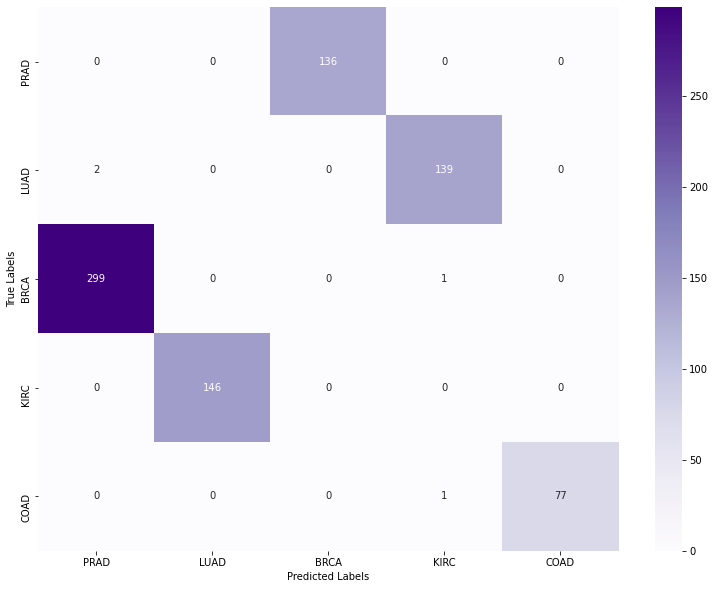

In [9]:
import seaborn as sns
# display confusion matrix here 
# your code here
encoded_labels, labels_map = pd.factorize(label['Class'])
c_matrix = confusion_matrix(encoded_labels, model.labels_)

# Plot
plt.figure(figsize=(13, 10))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=labels_map, yticklabels=labels_map)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### f) Change linkage method and distance metric. Which ones lead the best performance? Print out the accuracy and confusion matrix for the best model.
<br> Answer the Peer Review questions about this section. 

In [10]:
# programmatically evaluate which linkage method and distance metric lead to the best performance
# your code here
from datetime import timedelta

def get_str_timedelta(seconds):
    td = timedelta(seconds=seconds)
    return str(td)

LINKAGE = {'ward', 'complete', 'average', 'single'} # default='ward'
AFFINITY = {'euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed'}


neg_inf = -float('inf')
best_accuracy = (neg_inf, {"linkage":None, "affinity":None, "labelorder":None, "time":None})
best_accuracy_list = []
for linkage in LINKAGE:
    for affinity in AFFINITY:
        start_time = time.time()
        try:
            model = AgglomerativeClustering(n_clusters=5,linkage=linkage,affinity=affinity).fit(data)
            labelorder, accuracy = label_permute_compare(label, model.labels_)
            end_time = time.time()
            str_delta = get_str_timedelta(end_time - start_time)
            record = (accuracy, {"linkage":linkage, "affinity":affinity, "labelorder":labelorder, "time": str_delta})
            best_accuracy_list.append(record)
        except:
            print(f"   Invalid combination linkage:{linkage} + affinity:{affinity}")


print("\nBest accuracy:\n")
accuracy_df = pd.DataFrame([
    {"Accuracy": accuracy, **params} for accuracy, params in sorted(best_accuracy_list, key=lambda x: x[0], reverse=True)
])
print(accuracy_df)
             

   Invalid combination linkage:ward + affinity:l2
   Invalid combination linkage:ward + affinity:cosine
   Invalid combination linkage:ward + affinity:l1
   Invalid combination linkage:ward + affinity:precomputed
   Invalid combination linkage:ward + affinity:manhattan

Best accuracy:

    Accuracy   linkage     affinity       labelorder            time
0   0.995006      ward    euclidean  (2, 3, 0, 1, 4)  0:00:06.322143
1   0.931336  complete           l2  (4, 3, 1, 0, 2)  0:00:06.285052
2   0.931336  complete    euclidean  (4, 3, 1, 0, 2)  0:00:06.401138
3   0.740325  complete       cosine  (3, 4, 1, 2, 0)  0:00:06.132682
4   0.722846  complete           l1  (4, 3, 0, 1, 2)  0:00:06.256973
5   0.722846  complete    manhattan  (4, 3, 0, 1, 2)  0:00:06.305808
6   0.378277    single  precomputed  (1, 4, 0, 3, 2)  0:00:00.127710
7   0.377029   average  precomputed  (1, 3, 0, 2, 4)  0:00:00.158615
8   0.375780    single           l2  (1, 2, 0, 3, 4)  0:00:06.370153
9   0.375780    single 

### C. What about k-means clustering?
Can we apply kmeans clustering on this data? Which clustering methods give a better performance? Is kmeans faster or slower?

In [11]:
# try to apply kmeans clustering on this data
# time kmeans to compare to hierarchical clustering 
# your code here
init_t_kmeans = time.time()
kmeans = KMeans(5).fit(data)
final_t_kmeans = time.time()

print(f"KMeans total time: {get_str_timedelta(final_t_kmeans - init_t_kmeans)}")
labelorder, acc = label_permute_compare(label, kmeans.labels_)
print(labelorder, acc)
mapdict = dict(zip(list(label['Class'].unique()),list(labelorder)))
yt = label['Class'].apply(lambda x: mapdict[x])
print(acc)
confusion_matrix(yt,kmeans.labels_)

KMeans total time: 0:00:09.319080
(1, 3, 2, 0, 4) 0.9937578027465668
0.9937578027465668


array([[145,   0,   1,   0,   0],
       [  0, 136,   0,   0,   0],
       [  0,   0, 300,   0,   0],
       [  0,   0,   2, 139,   0],
       [  0,   0,   0,   2,  76]])